In [1]:
import os
import sys

sys.path.append('../../txf_design-space/')
sys.path.append('../../txf_design-space/flexibert')
sys.path.append('../../boshnas/boshnas/')
sys.path.append('../utils')
sys.path.append('../')

import yaml
import json
import time
import torch
import shlex
import shutil
import argparse
import subprocess
import collections
import numpy as np
from tqdm import tqdm

from embeddings.utils import graph_util, print_util as pu

sys.path.append('../../txf_design-space/transformers/src/transformers')
import embedding_util, energy_util

from boshnas import BOSHNAS
from acq import gosh_acq as acq

from transformers import BertModel
from transformers import RobertaTokenizer, RobertaModel
from transformers.models.bert.configuration_bert import BertConfig
from transformers.models.bert.modeling_modular_bert import BertModelModular, BertForMaskedLMModular, BertForSequenceClassificationModular

import warnings
warnings.filterwarnings("ignore")

from run_energy_profiler import *

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load design space
design_space = yaml.safe_load(open('../design_space/design_space.yaml'))

# Load dataset
dataset = json.load(open('../dataset/dataset_test.json'))
for key in dataset.keys():
    dataset[key]['embedding'] = eval(dataset[key]['embedding'])
    
X, latency, energy, peak_power = convert_to_tabular(dataset)
max_latency, max_energy, max_peak_power = np.amax(latency), np.amax(energy), np.amax(peak_power)

mean_X = np.mean(X, axis=0)

# Increase maximum values
max_latency, max_energy, max_peak_power = 1.2 * max_latency, 1.2 * max_energy, 1.2 * max_peak_power
print(f'Max latency: {max_latency : 0.3f}s/seq. Max energy: {max_energy : 0.3f}J/seq. Max peak power: {max_peak_power : 0.3f}W')
    
latency, energy, peak_power = latency/max_latency, energy/max_energy, peak_power/max_peak_power
    
# Get the embedding for model with hash in the first entry
model_hash = list(dataset.keys())[0]
print(np.array(dataset[model_hash]['embedding'])) 

surrogate_models = \
    init_surrogate_models('boshnas', dataset, design_space, '../dataset/surrogate_models/', True)

X_ds = convert_to_tabular({model_hash: dataset[model_hash]}, only_embeddings=True)

# We see a non-zero epistemic uncertainty
get_predictions(surrogate_models, X_ds-mean_X)

Max latency:  0.017s/seq. Max energy:  1.069J/seq. Max peak power:  360.696W
[  4   3 194 151   0 208   1   2 202 220   2 100 185   2 125 174   0  83
 154   1 214 126   3 128  38   2 223 106   2 192  60   0   0   0   0   0
   0]


(array([[6.3463574e-08, 1.0000000e+00]]),
 array([[1., 0.]]),
 array([[0., 1.]]),
 2.0,
 0)

In [ ]:
get_predictions(surrogate_models, (X-mean_X)/max_X)

In [ ]:
# Train surrogate models on the normalized dataset
train_surrogate_models(surrogate_models, (X-mean_X)/max_X, latency, energy, peak_power)

# We see a non-zero epistemic uncertainty
get_predictions(surrogate_models, (X-mean_X)/max_X)

In [ ]:
latency, energy, peak_power

In [ ]:
# Get random samples of the entire dataset to obtain maximum uncertainty
random_samples = embedding_util.get_samples(design_space, num_samples=128, sampling_method='Random', debug=True)
X_ds = convert_to_tabular(random_samples, only_embeddings=True)

# get_predictions(surrogate_models, (X_ds-mean_X)/max_X)

In [ ]:
len(set(random_samples.keys()).difference(set(dataset.keys())))

In [ ]:
# Test GP
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(random_state=0)
gpr.fit(X, latency)

print(gpr.predict(X, return_std=True))
gpr.predict(X_ds, return_std=True)

In [15]:
# Test different regressors on the dataset
regressors = ['GP', 'DT', 'BDT', 'BOSHNAS']

X, latency, energy, peak_power = X[:2048, :], latency[:2048], energy[:2048], peak_power[:2048]
X_train, latency_train = X[:16, :], latency[:16]
X_test, latency_test = X[16:20, :], latency[16:20]

for regressor in regressors:
    if regressor == 'BOSHNAS':
        embedding_dim = len(dataset[list(dataset.keys())[0]]['embedding'])
        embedding_bounds = embedding_util.get_embedding_bounds(design_space, 'all')
        embedding_bounds = (np.array([bound[0] for bound in embedding_bounds]), np.array([bound[1] for bound in embedding_bounds]))

        latency_model = BOSHNAS(input_dim=embedding_dim,
            bounds=embedding_bounds,
            trust_region=False,
            second_order=True,
            parallel=True,
            model_aleatoric=False,
            save_path='./surrogate_models_test',
            pretrained=False)
        
        latency_model.train(X_train, latency_train)
        latency_predictions = latency_model.predict(X_test)
        latency_predictions = np.array([pred[0].item() for pred in latency_predictions])
    elif regressor == 'GP':
        gpr = GaussianProcessRegressor(random_state=0)
        gpr.fit(X_train, latency_train)
        latency_predictions = gpr.predict(X_test)
    elif regressor == 'DT':
        dtr = DecisionTreeRegressor(random_state=0)
        dtr.fit(X_train, latency_train)
        latency_predictions = dtr.predict(X_test)
    elif regressor == 'BDT':
        bdtr = AdaBoostRegressor(DecisionTreeRegressor(random_state=0), n_estimators=500)
        bdtr.fit(X_train, latency_train)
        latency_predictions = bdtr.predict(X_test)
    print(f'MSE for {regressor}:\t{mean_squared_error(latency_test, latency_predictions): 0.5f}')

MSE for GP:	 0.19556
MSE for DT:	 0.00666
MSE for BDT:	 0.00099
MSE for BOSHNAS:	 0.19556


In [16]:
# Grid search validation of n_estimators for BDT
n_estimators_list = [5, 10, 50, 100, 200, 300, 500, 1000]

for n_estimators in n_estimators_list:
    bdtr = AdaBoostRegressor(DecisionTreeRegressor(random_state=0), n_estimators=n_estimators)
    bdtr.fit(X_train, latency_train)
    latency_predictions = bdtr.predict(X_test)
    print(f'MSE for BDT with {n_estimators} trees:\t{mean_squared_error(latency_test, latency_predictions): 0.5f}')

MSE for BDT with 5 trees:	 0.00378
MSE for BDT with 10 trees:	 0.00202
MSE for BDT with 50 trees:	 0.00264
MSE for BDT with 100 trees:	 0.00249
MSE for BDT with 200 trees:	 0.00085
MSE for BDT with 300 trees:	 0.00099
MSE for BDT with 500 trees:	 0.00070
MSE for BDT with 1000 trees:	 0.00099


In [4]:
sample_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048]
regressors = ['GP', 'DT', 'BDT', 'BOSHNAS']
max_uncertainties = {'GP': [], 'DT': [], 'BDT': [], 'BOSHNAS': []}
min_uncertainties = {'GP': [], 'DT': [], 'BDT': [], 'BOSHNAS': []}
mse = {'GP': [], 'DT': [], 'BDT': [], 'BOSHNAS': []}

for sample_size in sample_sizes:
    X_train_small, latency_train_small = X[:sample_size, :], latency[:sample_size]
    X_test_small, latency_test_small = X[sample_size:int(sample_size+128), :], latency[sample_size:int(sample_size+128)]

    for regressor in regressors:
        if regressor == 'GP':
            gpr = GaussianProcessRegressor(random_state=0)
            gpr.fit(X_train_small, latency_train_small)
            latency_predictions, uncertainty = gpr.predict(X_test_small, return_std=True)
        elif regressor == 'BOSHNAS':
            embedding_dim = len(dataset[list(dataset.keys())[0]]['embedding'])
            embedding_bounds = embedding_util.get_embedding_bounds(design_space, 'all')
            embedding_bounds = (np.array([bound[0] for bound in embedding_bounds]), np.array([bound[1] for bound in embedding_bounds]))

            latency_model = BOSHNAS(input_dim=embedding_dim,
                bounds=embedding_bounds,
                trust_region=False,
                second_order=True,
                parallel=True,
                model_aleatoric=False,
                save_path='./surrogate_models_test',
                pretrained=False)

            latency_model.train(X_train_small, latency_train_small)
            latency_predictions_all = latency_model.predict(X_test_small)
            latency_predictions = np.array([pred[0].item() for pred in latency_predictions_all])
            uncertainty = np.array([pred[1][0].item() for pred in latency_predictions_all])
        elif regressor == 'BDT':
            bdtr = AdaBoostRegressor(DecisionTreeRegressor(random_state=0), n_estimators=500)
            bdtr.fit(X_train_small, latency_train_small)

            dt_predictions = []
            for estimator in bdtr.estimators_:
                pred = estimator.predict(X_test_small)
                dt_predictions.append(pred)
            latency_predictions, uncertainty = bdtr.predict(X_test_small), np.std(np.array(dt_predictions), axis=0)
            
        elif regressor == 'DT':
            dtr = DecisionTreeRegressor(random_state=0)
            dtr.fit(X_train_small, latency_train_small)
            latency_predictions, uncertainty = dtr.predict(X_test_small), 0
        
        max_uncertainties[regressor].append(np.amax(uncertainty))
        min_uncertainties[regressor].append(np.amin(uncertainty))
        mse[regressor].append(mean_squared_error(latency_test_small, latency_predictions))

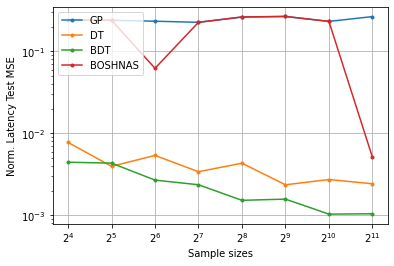

In [17]:
for regressor in regressors:
    plt.plot(sample_sizes, min_uncertainties[regressor], label=regressor)
plt.legend()
plt.xlabel('Sample sizes')
plt.xscale('log', basex=2)
plt.xticks(sample_sizes)
plt.ylabel('Min. Uncertainty')
plt.show()

for regressor in regressors:
    plt.plot(sample_sizes, max_uncertainties[regressor], label=regressor)
plt.legend()
plt.xlabel('Sample sizes')
plt.xscale('log', basex=2)
plt.xticks(sample_sizes)
plt.ylabel('Max. Uncertainty')
plt.show()

for regressor in regressors:
    plt.plot(sample_sizes, mse[regressor], '.-', label=regressor)
plt.legend(loc='upper left')
plt.xlabel('Sample sizes')
plt.xscale('log', basex=2)
plt.yscale('log')
plt.xticks(sample_sizes)
plt.ylabel('Norm. Latency Test MSE')
plt.grid()
plt.savefig('./latency_test_mse.pdf', bbox_inches='tight')
plt.show()

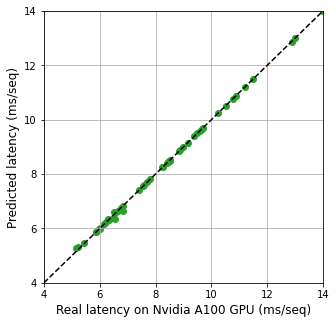

In [77]:
from matplotlib.pyplot import figure

figure(figsize=(5, 5))

sample_size = 256
X_train_small, latency_train_small = X[:int(0.8*sample_size), :], latency[:int(0.8*sample_size)]
X_test_small, latency_test_small = X[int(0.8*sample_size):sample_size, :], latency[int(0.8*sample_size):sample_size]

plt.scatter(latency_test_small*max_latency, bdtr.predict(X_test_small)*max_latency, color='tab:green')
plt.plot(np.arange(0.004, 0.015, 0.001), np.arange(0.004, 0.015, 0.001), '--', color='black')
plt.xlim([0.004, 0.014])
plt.ylim([0.004, 0.014])
plt.xticks(np.arange(0.004, 0.015, 0.002), [4, 6, 8, 10, 12, 14])
plt.yticks(np.arange(0.004, 0.015, 0.002), [4, 6, 8, 10, 12, 14])
plt.grid()
plt.xlabel('Real latency on Nvidia A100 GPU (ms/seq)', fontsize=12)
plt.ylabel('Predicted latency (ms/seq)', fontsize=12)
plt.savefig('./pred_vs_real_latency_bdt.pdf', bbox_inches='tight')